In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from collections import Counter
import heapq
from operator import itemgetter
from multiprocessing import Pool
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Flatten
from tensorflow.keras.regularizers import l1_l2
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt


In [4]:
# Load dataset

df = pd.read_csv("./dataset/news.csv")

In [5]:
df = df.head(1000)

og_shape = df.shape

In [6]:
df = df.drop(columns=['Unnamed: 0', 'title'])

One hot encoding the label 

In [7]:
label_map = {'REAL': 0, 'FAKE': 1}
df['label'] = df['label'].map(label_map)


Some lines of data are incomplete, empty, or only have the beginning of an article. We remove rows of data that have a number of letters below a certain threshold.


In [8]:
size_mini = 1000

df = df.loc[df['text'].str.len() > size_mini]

print("We have kept", (df.shape[0]/og_shape[0])*100, "% of the data")


We have kept 85.0 % of the data


In [9]:
def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

def clean_numbers(x):
    digit_map = {
        '0': 'zero',
        '1': 'one',
        '2': 'two',
        '3': 'three',
        '4': 'four',
        '5': 'five',
        '6': 'six',
        '7': 'seven',
        '8': 'eight',
        '9': 'nine'
    }
    
    x = re.sub('[0-9]{7,}', 'millions', x)
    x = re.sub('[0-9]{4,6}', 'thousand', x)
    x = re.sub('[0-9]{3}', 'hundred', x)
    x = re.sub('[0-9]{2}', 'tens', x)
    x = re.sub('[0-9]{1}', 'tens', x)
    x = re.sub(r'\b\d\b', lambda match: digit_map[match.group()], x)

    return x
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)


df['text'] = df["text"].apply(clean_text)
df['text'] = df["text"].apply(clean_numbers)
df['text'] = df["text"].apply(replace_contractions)


In [10]:
df['text_length'] = df['text'].apply(lambda x: len(x.split()))

# Determine the 95th percentile of these lengths
sequence_length_95 = np.percentile(df['text_length'], 95)

sequence_length = int(np.ceil(sequence_length_95))

print(f"Length covering at least 95% of the news: {sequence_length}")
df = df.drop(columns=["text_length"])
print("The kept sequence is: ", sequence_length, " words")


Length covering at least 95% of the news: 2248
The kept sequence is:  2248  words


In [11]:
max_features = 10000

vectorization = TextVectorization(standardize="lower_and_strip_punctuation", 
                                  max_tokens=max_features, 
                                  output_mode='int', 
                                  output_sequence_length=sequence_length)
vectorization.adapt(df["text"])

words_database = vectorization.get_vocabulary()
database_index = {word: index for index, word in enumerate(words_database)}


Utilize Glove Twitter Embedding


In [12]:
def load_glove_index():
    EMBEDDING_FILE = 'glove.twitter.27B.200d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, 'r', encoding='utf-8'))
    return embeddings_index

glove_embedding_index_twitter = load_glove_index()

In [13]:
import numpy as np
from tqdm import tqdm

def create_glove(word_index, embeddings_index):
    all_embs = list(embeddings_index.values())  # Convert values to list
    embed_size = all_embs[0].shape[0]  # Assuming all embeddings have the same size
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(0, 1, (nb_words, embed_size))

    count_found = nb_words
    for word, i in tqdm(word_index.items()):
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] =  embedding_vector
        else:
            if word.islower():
                embedding_vector = embeddings_index.get(word.capitalize())
                if embedding_vector is not None: 
                    embedding_matrix[i] = embedding_vector
                else:
                    count_found -= 1
            else:
                count_found -= 1
    print("We found", count_found, "words")
    return embedding_matrix


In [14]:
adapted_glove_twitter = create_glove(database_index, glove_embedding_index_twitter)

embedding_dim = 200
embedding_layer = Embedding(input_dim=max_features, output_dim=embedding_dim, weights=[adapted_glove_twitter], input_length=sequence_length, trainable=False)


100%|██████████| 10000/10000 [00:00<00:00, 230208.35it/s]

We found 9233 words



/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [32]:
def simple_rnn_model():
    model = Sequential()
    model.add(tf.keras.Input(shape=(1,), dtype=tf.string))  # Input layer for raw strings
    model.add(vectorization)
    model.add(embedding_layer)
    model.add(SimpleRNN(128, return_sequences=True))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu', kernel_regularizer=l1_l2(0.01)))
    model.add(Dense(1, activation='sigmoid'))

    return model

model = simple_rnn_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [33]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 2248)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 2248, 200)      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 2248, 128)      │        42,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,050,433 (7.82 MB)

 Trainable params: 50,433 (197.00 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [40]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=10)


history = model.fit(train_df['text'], train_df['label'], epochs=20, validation_data=(test_df['text'], test_df['label']))


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 689ms/step - accuracy: 0.9241 - loss: 2.4096 - val_accuracy: 0.7824 - val_loss: 2.0806
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 700ms/step - accuracy: 0.9455 - loss: 1.8049 - val_accuracy: 0.8059 - val_loss: 1.6281
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 693ms/step - accuracy: 0.9511 - loss: 1.3876 - val_accuracy: 0.8235 - val_loss: 1.3332
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 644ms/step - accuracy: 0.9774 - loss: 1.1032 - val_accuracy: 0.8059 - val_loss: 1.1713
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 765ms/step - accuracy: 0.9851 - loss: 0.9144 - val_accuracy: 0.8059 - val_loss: 1.0492
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 811ms/step - accuracy: 0.9861 - loss: 0.7733 - val_accuracy: 0.8471 - val_loss: 0.9092
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 889ms/step - accuracy: 0.9957 - loss: 0.6484 - val_accuracy: 0.8647 - val_loss: 0.8227
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 843ms/step - accuracy: 0.9955 - loss: 0.5693 - val_accu

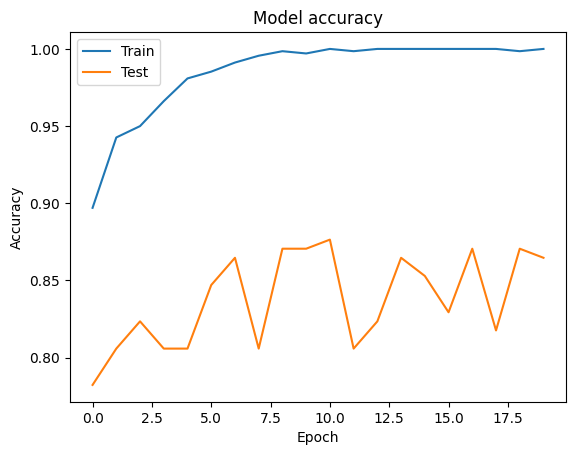

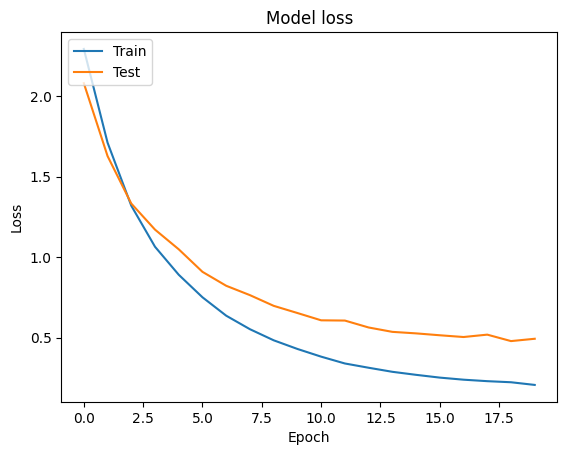

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [42]:
loss, accuracy = model.evaluate(test_df["text"], test_df['label'])

pred = model.predict(test_df['text'])

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - accuracy: 0.8607 - loss: 0.4900
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 292ms/step


In [43]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred_classes = (pred >= 0.5).astype(int)

# pred_classes = pred_classes.squeeze(axis=-1)  

# Check values and print unique values
print("Unique values in test_df['label']: ", test_df['label'].unique())
print("Unique values in pred_classes: ", np.unique(pred_classes))

# Check for missing values
print("Missing values in test_df['label']: ", test_df['label'].isnull().sum())
print("Missing values in pred_classes: ", np.isnan(pred_classes).sum())

# Check dimensions
print("Shape of test_df['label']: ", test_df['label'].shape)
print("Shape of pred_classes: ", pred_classes.shape)
# pred_classes = pred_classes.squeeze(axis=-1)
# print("Shape of pred_classes: ", pred_classes.shape)
# pred_classes_binary = (pred_classes >= 0.5).astype(int)
# pred_classes_binary = np.argmax(pred_classes, axis=1)

# print("Shape of pred_classes_binary: ", pred_classes_binary.shape)

# # Compute confusion matrix
# conf_mat = confusion_matrix(test_df['label'], pred_classes)
# sns.heatmap(conf_mat, annot=True)


Unique values in test_df['label']:  [0 1]
Unique values in pred_classes:  [0 1]
Missing values in test_df['label']:  0
Missing values in pred_classes:  0
Shape of test_df['label']:  (170,)
Shape of pred_classes:  (170, 1)


<Axes: >

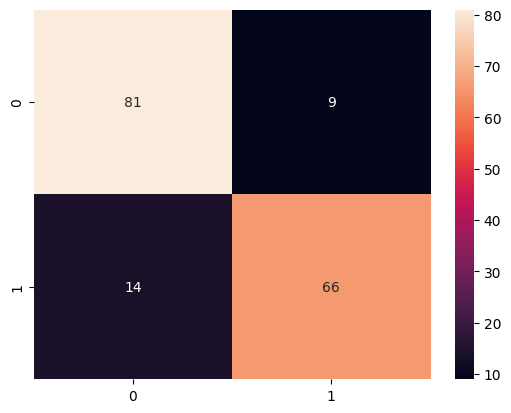

In [44]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix

conf_mat = confusion_matrix(test_df['label'], pred_classes)
sns.heatmap(conf_mat, annot=True)


In [45]:
print(classification_report(test_df['label'], pred_classes, target_names=['True', 'Fake']))


              precision    recall  f1-score   support

        True       0.85      0.90      0.88        90
        Fake       0.88      0.82      0.85        80

    accuracy                           0.86       170
   macro avg       0.87      0.86      0.86       170
weighted avg       0.87      0.86      0.86       170

